In [3]:
import pandas as pd
import numpy as np

rng = np.random.RandomState(1)

def generate_data(n_samples=30):
    """Generate synthetic dataset. Returns 'data_train', 'data_test', 'target_train'"""
    x_min, x_max = -3, 3
    x = rng.uniform(x_min, x_max, size=n_samples)
    noise = 4.0 * rng.randn(n_samples)
    y = x**3 - 0.5 * (x+1)**2 + noise
    y /= y.std()

    data_train = pd.DataFrame(x, columns=['Feature'])
    #linspace is evenly spaced, uniform maintains some degree of randomness
    data_test = pd.DataFrame(np.linspace(x_min, x_max, num=300), columns=['Feature'])
    target_train = pd.Series(y, name='Target')

    return data_train, data_test, target_train

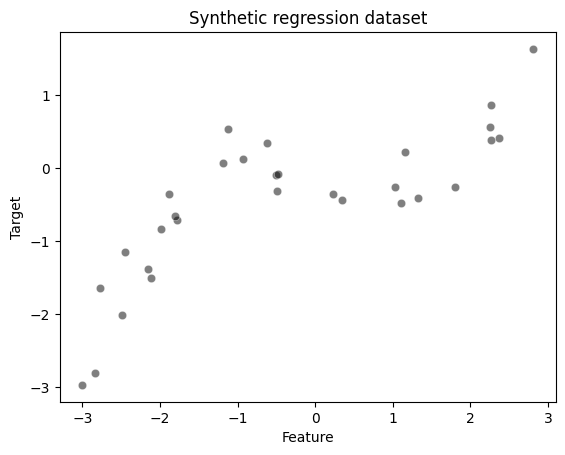

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

data_train, data_test, target_train = generate_data(n_samples=30)
sns.scatterplot(
    x=data_train["Feature"], y=target_train, color="black", alpha=0.5
)

_ = plt.title("Synthetic regression dataset")


In [5]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=3, random_state=0)
tree.fit(data_train, target_train)
y_pred = tree.predict(data_test)

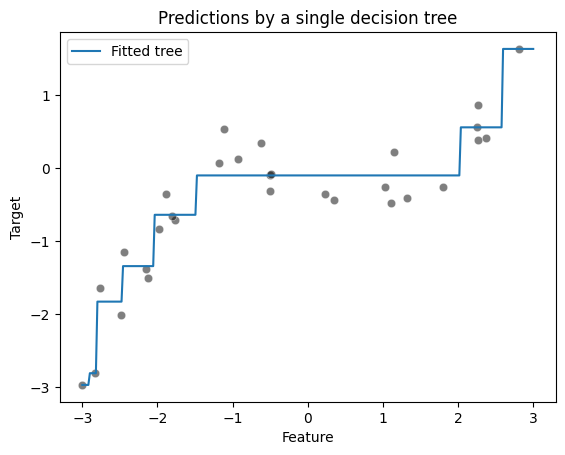

In [6]:
sns.scatterplot(
    x = data_train["Feature"], y=target_train, color="black", alpha=0.5
)
plt.plot(data_test["Feature"], y_pred, label="Fitted tree")
plt.legend()
_ = plt.title("Predictions by a single decision tree")

In [7]:
def bootstrap_sample(data, target):
    bootstrap_indices = rng.choice(#randomsly selects indices
        np.arange(target.shape[0]),#array of indices i.e. if target has length N, creates array [0, 1, ..., N-1]
        size=target.shape[0],
        replace=True#same indice can be selected more than once
    )
    data_bootstrap = data.iloc[bootstrap_indices]
    target_bootstrap = target.iloc[bootstrap_indices]
    return data_bootstrap, target_bootstrap

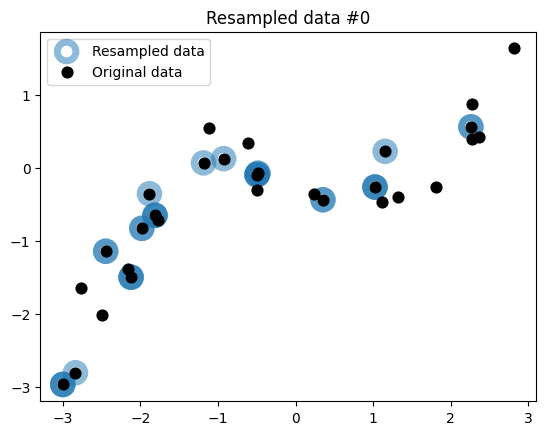

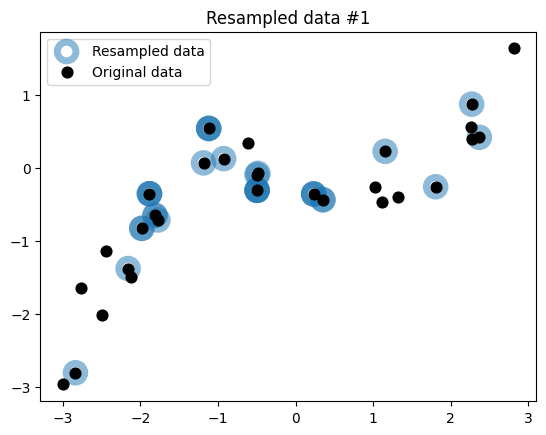

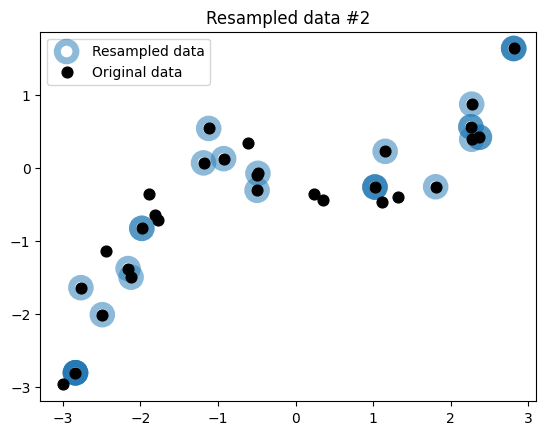

In [10]:
n_bootstraps = 3
for bootstrap_idx in range(n_bootstraps):
    data_bootstrap, target_bootstrap = bootstrap_sample(
        data_train,
        target_train
    )
    plt.figure()
    plt.scatter(
        data_bootstrap["Feature"],
        target_bootstrap,
        color="tab:blue",
        facecolors="none",
        alpha=0.5,
        label="Resampled data",
        s=180,
        linewidth=5,
    )
    plt.scatter(
        data_train["Feature"],
        target_train,
        color="black",
        s=60,
        alpha=1,
        label="Original data"
    
    )
    plt.title(f"Resampled data #{bootstrap_idx}")
    plt.legend()

In [7]:
data_train_huge, data_test_huge, target_train_huge = generate_data(
    n_samples=100_000
)
data_bootstrap_sample, target_bootstrap_sample = bootstrap_sample(
    data_train_huge, target_train_huge
)

ration_unique_sample = (
    np.unique(data_bootstrap_sample).size / data_bootstrap_sample.size
)

print("Percentage of samples present in the original dataset: "
      f"{ration_unique_sample * 100:.1f}")

Percentage of samples present in the original dataset: 63.2


In [8]:
bag_of_trees = []
for bootstrap_idx in range(n_bootstraps):
    tree = DecisionTreeRegressor(max_depth=3, random_state=0)
    data_bootstrap_sample, target_bootstrap_sample = bootstrap_sample(
        data_train, target_train
    )
    tree.fit(data_bootstrap_sample, target_bootstrap_sample)
    bag_of_trees.append(tree)

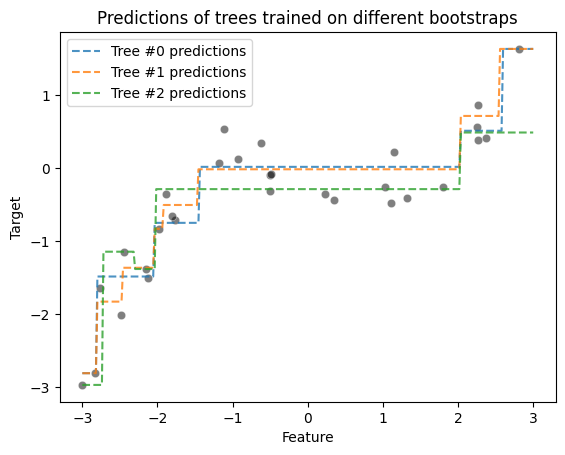

In [9]:
sns.scatterplot(
    x=data_train["Feature"], y=target_train, color="black", alpha=0.5
)
for tree_idx, tree in enumerate(bag_of_trees):
    tree_predictions = tree.predict(data_test)
    plt.plot(
        data_test["Feature"],
        tree_predictions,
        linestyle="--",
        alpha=0.8,
        label=f"Tree #{tree_idx} predictions",
    )

plt.legend()
_ = plt.title("Predictions of trees trained on different bootstraps")

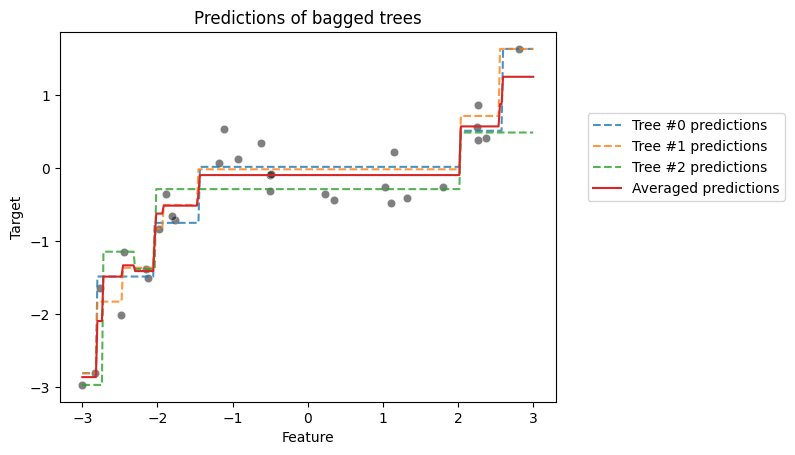

In [10]:
sns.scatterplot(
    x=data_train["Feature"], y=target_train, color="black", alpha=0.5
)
bag_predictions = []
for tree_idx, tree in enumerate(bag_of_trees):
    tree_predictions = tree.predict(data_test)
    plt.plot(
        data_test["Feature"],
        tree_predictions,
        linestyle="--",
        alpha=0.8,
        label=f"Tree #{tree_idx} predictions",
    )
    bag_predictions.append(tree_predictions)

bag_predictions = np.mean(bag_predictions, axis=0)
plt.plot(
    data_test["Feature"],
    bag_predictions,
    label="Averaged predictions",
    linestyle="-",
)
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
_ = plt.title("Predictions of bagged trees")

In [11]:
from sklearn.ensemble import BaggingRegressor

bagged_trees = BaggingRegressor(
    estimator=DecisionTreeRegressor(max_depth=3),
    n_estimators=100
)
_ = bagged_trees.fit(data_train, target_train)

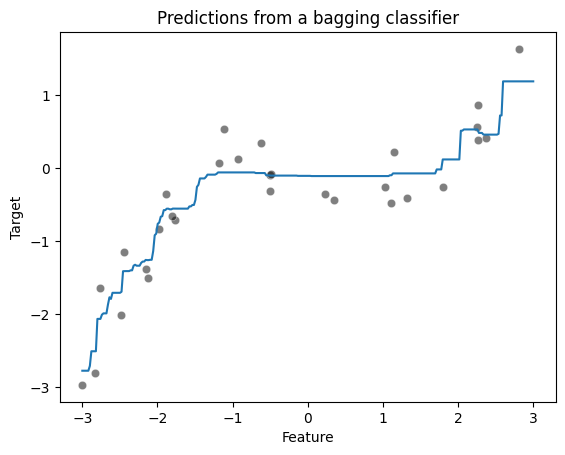

In [12]:
sns.scatterplot(
    x=data_train["Feature"], y=target_train, color="black", alpha=0.5
)
bagged_trees_predictions = bagged_trees.predict(data_test)
plt.plot(data_test["Feature"], bagged_trees_predictions)

_ = plt.title("Predictions from a bagging classifier")

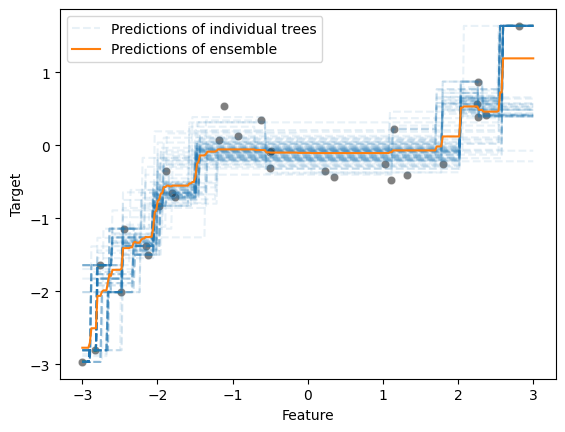

In [14]:
for tree_idx, tree in enumerate(bagged_trees.estimators_):
    label = "Predictions of individual trees" if tree_idx == 0 else None
    tree_predictions = tree.predict(data_test.to_numpy())
    plt.plot(
        data_test["Feature"],
        tree_predictions,
        linestyle="--",
        alpha=0.1,
        color="tab:blue",
        label=label
    )

sns.scatterplot(
    x=data_train["Feature"], y=target_train, color="black", alpha=0.5
)

bagged_trees_predictions = bagged_trees.predict(data_test)
plt.plot(
    data_test["Feature"],
    bagged_trees_predictions,
    color="tab:orange",
    label="Predictions of ensemble",
)
_ = plt.legend()

In [16]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline

polynomial_regressor = make_pipeline(
    MinMaxScaler(),
    PolynomialFeatures(degree=4),
    Ridge(alpha=1e-10)
)

In [17]:
bagging = BaggingRegressor(
    estimator = polynomial_regressor,
    n_estimators=100,
    random_state=0,
)
_ = bagging.fit(data_train, target_train)

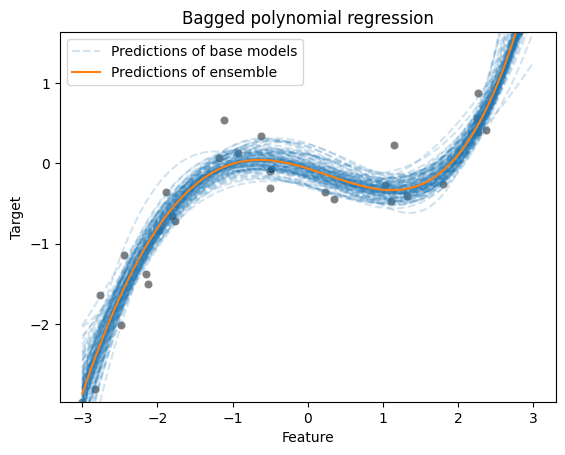

In [18]:
for i, regressor in enumerate(bagging.estimators_):
    regressor_predictions = regressor.predict(data_test.to_numpy())
    base_model_line = plt.plot(
        data_test["Feature"],
        regressor_predictions,
        linestyle="--",
        alpha=0.2,
        label = "Predictions of base models" if i==0 else None,
        color = "tab:blue"
    )
sns.scatterplot(
    x=data_train["Feature"], y=target_train, color="black", alpha=0.5
)
bagging_predictions = bagging.predict(data_test)
plt.plot(
    data_test["Feature"],
    bagging_predictions,
    color="tab:orange",
    label="Predictions of ensemble"
)
plt.ylim(target_train.min(), target_train.max())
plt.legend()
_ = plt.title("Bagged polynomial regression")